In [1]:
#Import libraries
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import gdown

# Load dataset

In [2]:

# Google Drive file URL
file_url = "https://drive.google.com/uc?id=1Td-bf5TFYBsuikFCt5eurDa0x6-bkDr4"

# Output file path 
output_file = 'brfss_data.csv'  

# Download the file
gdown.download(file_url, output_file, quiet=False)

# Read the downloaded CSV file
df = pd.read_csv(output_file)

# Connect to SQLite database (it will create a file if it doesn't exist)
conn = sqlite3.connect('brfss_data.db')

# Write the DataFrame to a table in the database
table_name = 'brfss_data'
df.to_sql(table_name, conn, if_exists='replace', index=False)

print(f"Data has been successfully imported into the table '{table_name}'.")

# Close the connection
conn.close()




Downloading...
From (original): https://drive.google.com/uc?id=1Td-bf5TFYBsuikFCt5eurDa0x6-bkDr4
From (redirected): https://drive.google.com/uc?id=1Td-bf5TFYBsuikFCt5eurDa0x6-bkDr4&confirm=t&uuid=6d053054-568e-41d7-ac00-bdeb15866a8e
To: /home/nicole/code/nicole-baltodano/MS Data Science/summer_project/brfss_data.csv
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 914M/914M [00:33<00:00, 27.3MB/s]


Data has been successfully imported into the table 'brfss_data'.


In [3]:
# Reconnect to the database
conn = sqlite3.connect('brfss_data.db')

# Query the data
query = "SELECT * FROM brfss_data"
data = pd.read_sql_query(query, conn)

# Close the connection
conn.close()


# Analyze dataset

In [4]:
data.shape

(2763102, 27)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2763102 entries, 0 to 2763101
Data columns (total 27 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Year                        int64  
 1   Locationabbr                object 
 2   Locationdesc                object 
 3   Class                       object 
 4   Topic                       object 
 5   Question                    object 
 6   Response                    object 
 7   Break_Out                   object 
 8   Break_Out_Category          object 
 9   Sample_Size                 int64  
 10  Data_value                  float64
 11  Confidence_limit_Low        float64
 12  Confidence_limit_High       float64
 13  Display_order               float64
 14  Data_value_unit             object 
 15  Data_value_type             object 
 16  Data_Value_Footnote_Symbol  object 
 17  Data_Value_Footnote         object 
 18  DataSource                  object 
 19  ClassId              

In [6]:
#if column Data_Value_Footnote_Symbol = * or ***  
#indicates suppression due to small sample sizes or other factors affecting data reliability
#dropping rows with * or **
data = data[~data['Data_Value_Footnote_Symbol'].isin(['*', '***'])]

In [7]:
#drop rows where sample_size = 0
data = data[data['Sample_Size'] != 0]

In [8]:
data.isnull().sum()
#Geolocation not relevant cause we have location columns
#Confidence limit calculated value not relevant
#display_order not relevant for analysis
#data_value blank indicates data is good

Year                                0
Locationabbr                        0
Locationdesc                        0
Class                               0
Topic                               0
Question                            0
Response                        16376
Break_Out                           0
Break_Out_Category                  0
Sample_Size                         0
Data_value                          0
Confidence_limit_Low             4232
Confidence_limit_High            4232
Display_order                     594
Data_value_unit                     0
Data_value_type                     0
Data_Value_Footnote_Symbol    2229766
Data_Value_Footnote           2229766
DataSource                          0
ClassId                             0
TopicId                             0
LocationID                          0
BreakoutID                          0
BreakOutCategoryID                  0
QuestionID                          0
ResponseID                          0
GeoLocation 

In [9]:
# Group by 'Class' and aggregate unique 'Topic' values
class_topic_mapping = (
    data.groupby('Class')['Topic']
    .apply(lambda x: x.unique().tolist())
    .to_dict()
)

# Print the mapping
for class_name, topics in class_topic_mapping.items():
    print(f"Class: {class_name}")
    print(f"Topics: {topics}\n")

Class: Alcohol Consumption
Topics: ['Alcohol Consumption', 'Binge Drinking', 'Heavy Drinking']

Class: Cholesterol Awareness
Topics: ['Cholesterol Checked', 'Cholesterol High']

Class: Chronic Health Indicators
Topics: ['COPD', 'Cardiovascular Disease', 'Asthma', 'Arthritis', 'Depression', 'Diabetes', 'Kidney', 'Other Cancer', 'Skin Cancer', 'Vision']

Class: Colorectal Cancer Screening
Topics: ['Blood Stool Test', 'Sigmoidoscopy', 'USPSTF Recommendations', 'Colonoscopy']

Class: Days of Poor Health
Topics: ['Healthy Days']

Class: Demographics
Topics: ['Age', 'Disability status', 'Employment', 'Race', 'Education', 'Income', 'Marital Status', 'Number of Children', 'Sex', 'Internet', 'Rent/Own Home', 'Veteran Status', 'Hearing']

Class: E-Cigarette Use
Topics: ['E-Cigarette Use']

Class: Fruits and Vegetables
Topics: ['Fruit Consumption', 'Vegetable Consumption']

Class: HIV-AIDS
Topics: ['HIV Test']

Class: Health Care Access/Coverage
Topics: ['Health Care Coverage', 'Under 65 Coverage

In [10]:
# Filter data for 'Chronic Health Indicators' class and 'Diabetes' topic
filtered_data = data[(data['Class'] == 'Chronic Health Indicators') & (data['Topic'] == 'Diabetes')]

# Extract unique values from the 'Break_Out_Category' column
break_out_category_values = filtered_data['Break_Out_Category'].unique()

# Convert to a list for easy readability
break_out_category_values_list = break_out_category_values.tolist()

# Display the result
print("Unique values in 'Break_Out_Category':", break_out_category_values_list)

Unique values in 'Break_Out_Category': ['Age Group', 'Overall', 'Education Attained', 'Household Income', 'Race/Ethnicity', 'Gender']


In [11]:
filtered_data.shape

(43943, 27)

In [12]:
#Survey question:

filtered_data['Question'].unique()

array(['Have you ever been told by a doctor that you have diabetes?'],
      dtype=object)

In [13]:
#Filtering dataset dropping non relevant columns 

filtered_data = filtered_data[['Year', 'Locationabbr','Response', 'Break_Out', 'Break_Out_Category', 'Sample_Size']]
filtered_data.shape

(43943, 6)

In [14]:
# Expanding rows based on Sample_Size
expanded_data = filtered_data.loc[filtered_data.index.repeat(filtered_data['Sample_Size'])].drop(columns=['Sample_Size']).reset_index(drop=True)

# Display the resulting dataframe
expanded_data.head(2)

,Year,Locationabbr,Response,Break_Out,Break_Out_Category
0,2011,AL,No,18-24,Age Group
1,2011,AL,No,18-24,Age Group


In [15]:
expanded_data.shape

(34004597, 5)

In [16]:
expanded_data.head()

,Year,Locationabbr,Response,Break_Out,Break_Out_Category
0,2011,AL,No,18-24,Age Group
1,2011,AL,No,18-24,Age Group
2,2011,AL,No,18-24,Age Group
3,2011,AL,No,18-24,Age Group
4,2011,AL,No,18-24,Age Group


In [17]:
# Get the unique Break_Out_Category values
break_out_categories = expanded_data['Break_Out_Category'].unique().tolist()

#get unique responses values
responses = expanded_data['Response'].unique().tolist()


In [18]:
print(break_out_categories)
print(responses)

['Age Group', 'Overall', 'Education Attained', 'Household Income', 'Race/Ethnicity', 'Gender']
['No', 'Yes', 'Yes, pregnancy-related', 'No, pre-diabetes or borderline diabetes']


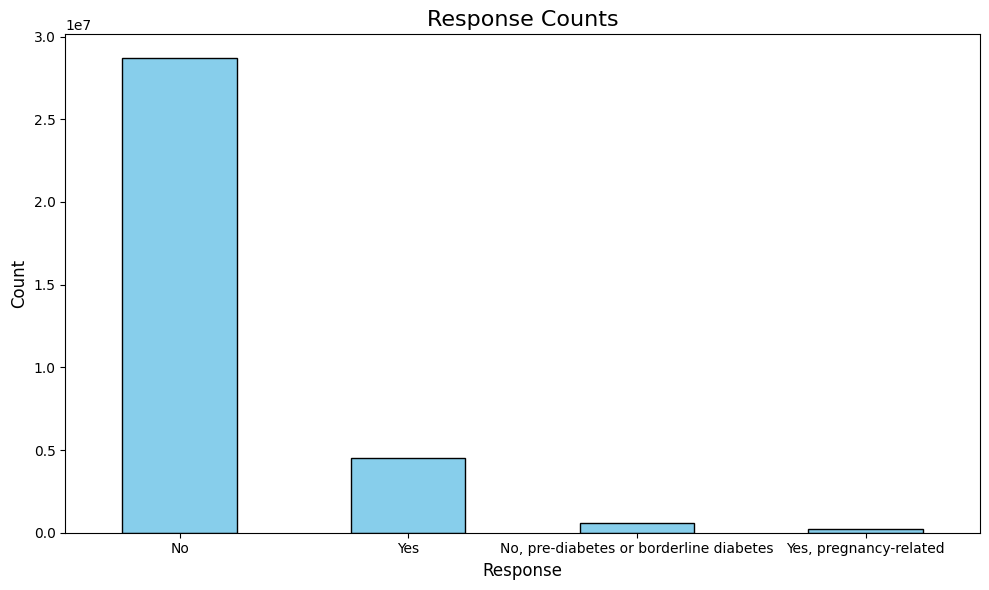

In [19]:
#Target is imbalanced
# Count the occurrences of each Response in the dataset
response_counts = expanded_data['Response'].value_counts()

# Plot the counts as a bar chart
response_counts.plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black')

# Customize the plot
plt.title('Response Counts', fontsize=16)
plt.xlabel('Response', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

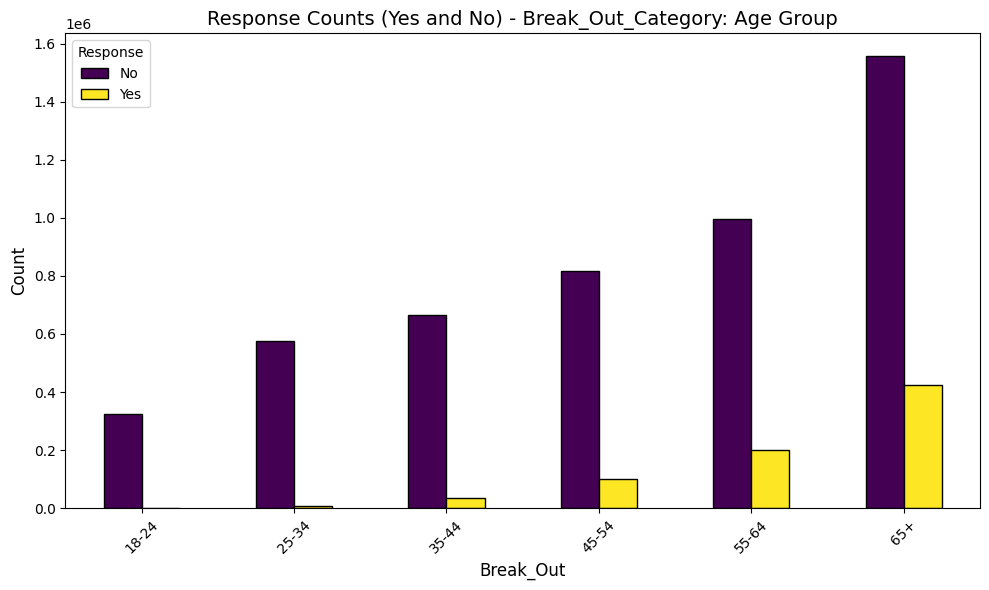

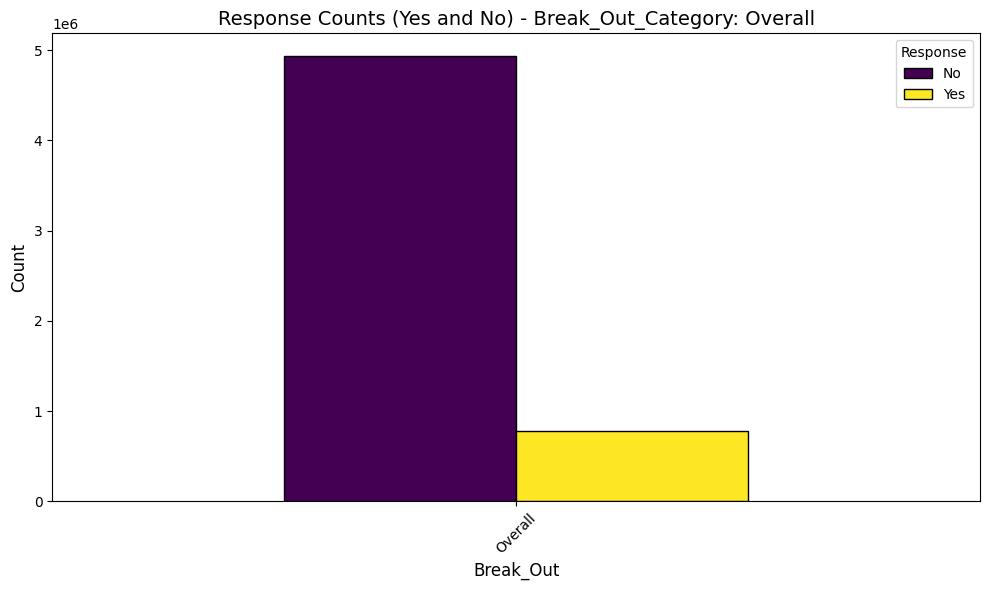

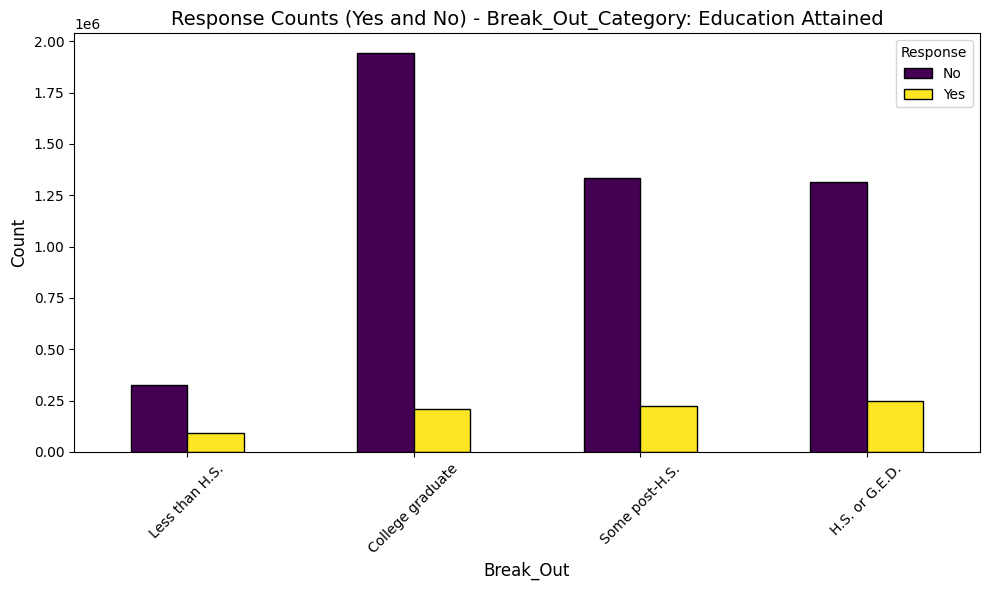

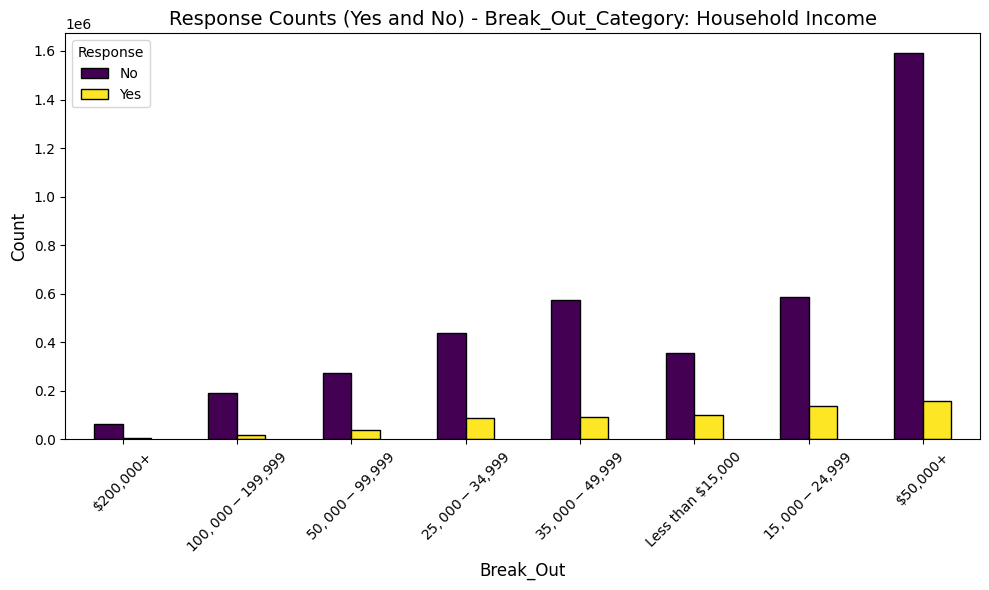

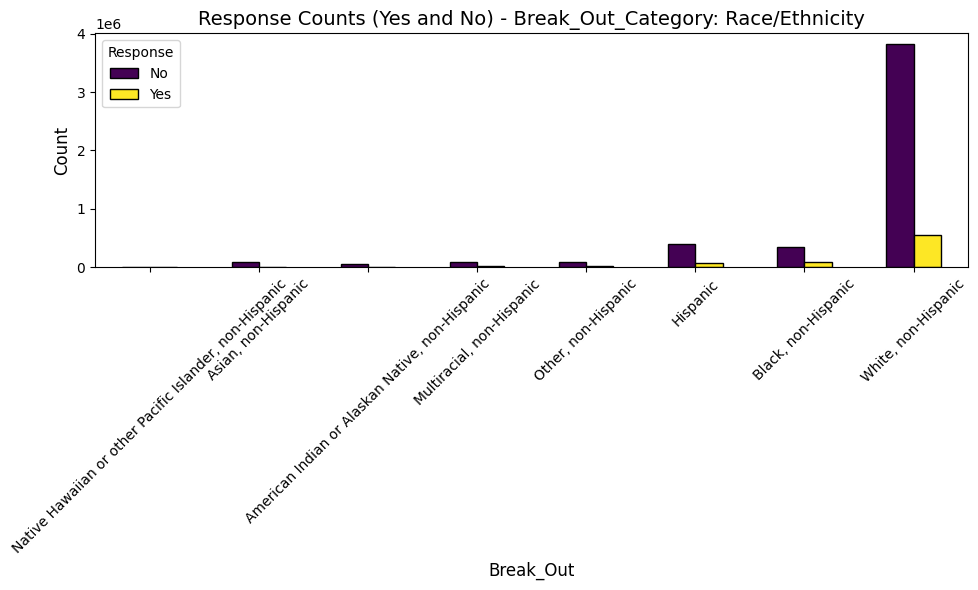

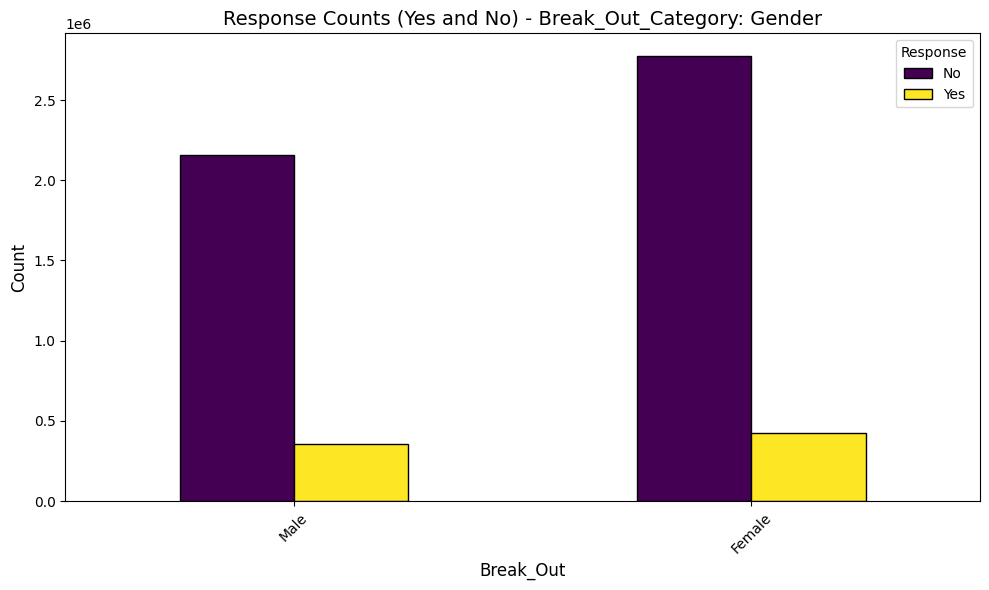

In [20]:
# Filter and plot 'Yes' and 'No' responses in the same chart for each Break_Out_Category
for category in break_out_categories:
    # Filter data for the current Break_Out_Category
    filtered_data = expanded_data[expanded_data['Break_Out_Category'] == category]
    
    # Count occurrences of 'Yes' and 'No' responses by Break_Out
    counts = filtered_data[filtered_data['Response'].isin(['Yes', 'No'])].groupby(['Break_Out', 'Response']).size().unstack(fill_value=0)
    
    # Sort by 'Yes' counts in ascending order
    if 'Yes' in counts.columns:  # Ensure 'Yes' exists to avoid errors
        counts = counts.sort_values(by='Yes', ascending=True)
    
    # Plot the results
    counts.plot(kind='bar', figsize=(10, 6), stacked=False, colormap='viridis', edgecolor='black')
    
    # Customize the plot
    plt.title(f'Response Counts (Yes and No) - Break_Out_Category: {category}', fontsize=14)
    plt.xlabel('Break_Out', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.legend(title='Response', fontsize=10)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

## Observations 


- **Age**: Older groups (e.g., 55–64, 65+) have relatively more "Yes" responses compared to younger groups. This aligns with the higher risk of diabetes in older populations.
- **Income**: Lower-income groups show proportionally higher "Yes" responses, consistent with socioeconomic disparities in health outcomes.
- **Education**: Less educated groups show slightly higher "Yes" responses, which might relate to lower access to preventive healthcare or health literacy.

### Imbalance in the dataset 

- Race/Ethnicity:
White, non-Hispanic respondents dominate the dataset.
Other racial/ethnic groups (e.g., Hispanic, Black, Asian) are underrepresented.

- Income:
Respondents in higher-income categories (e.g., $50,000+) are overrepresented, whereas lower-income groups (e.g., <$15,000) are underrepresented.

- Education:
Individuals with higher educational attainment dominate the dataset.

- Age:
Younger respondents (e.g., 18–24) have lower response counts than older groups like 65+


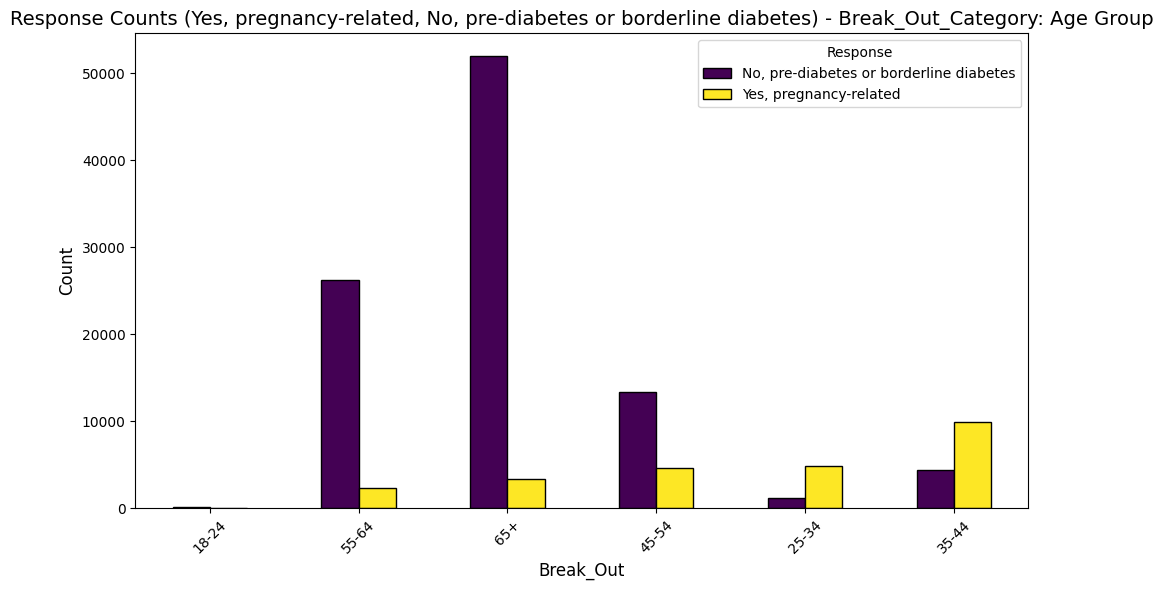

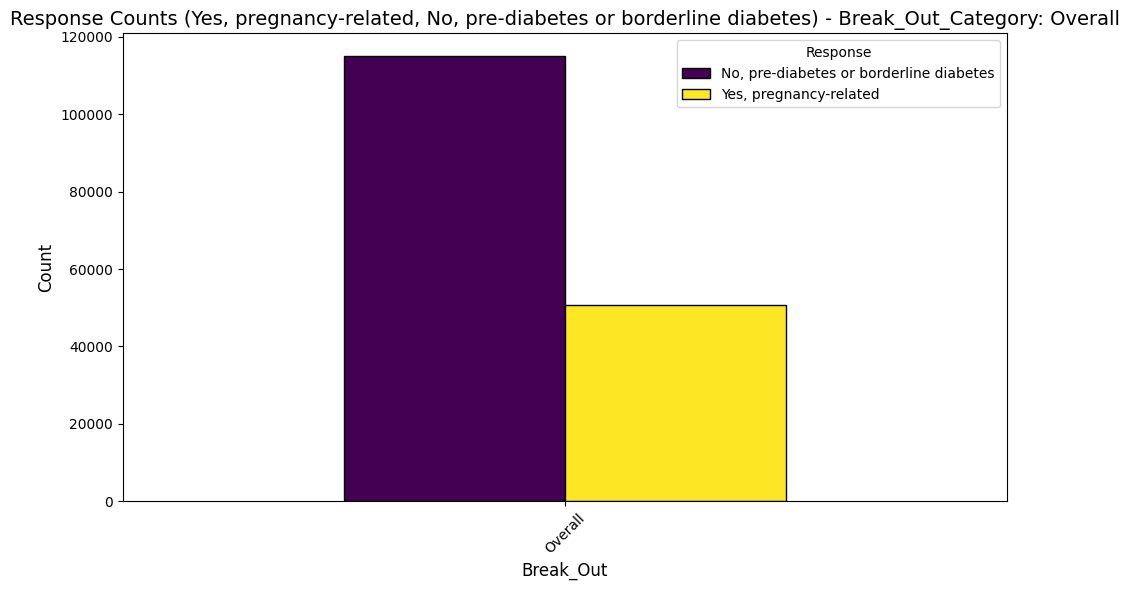

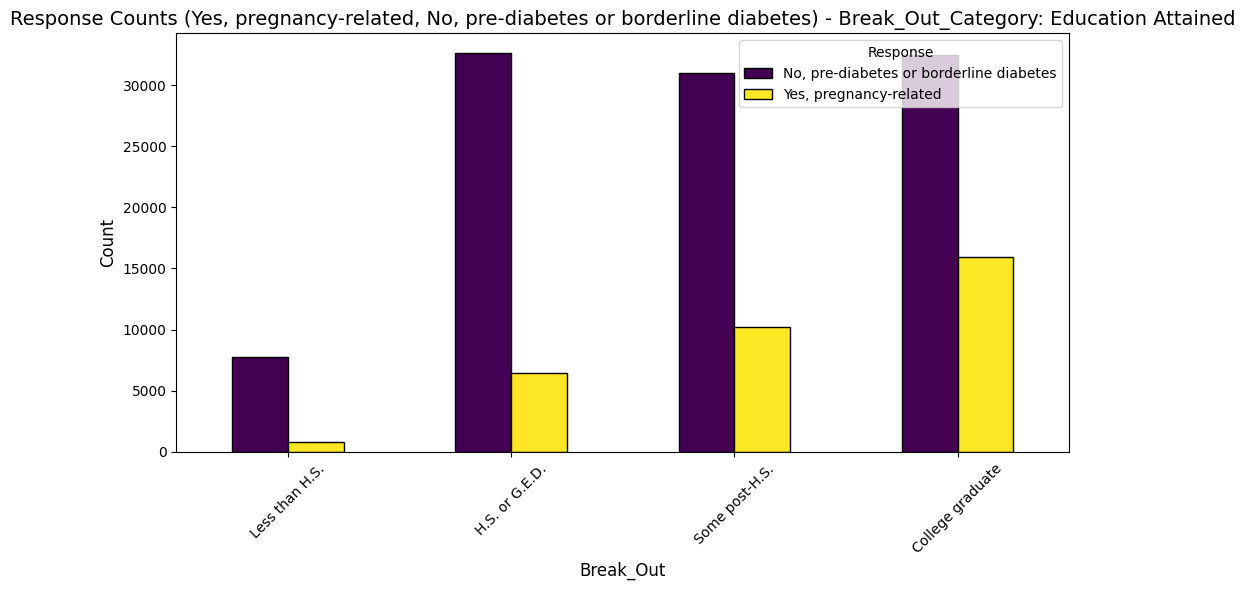

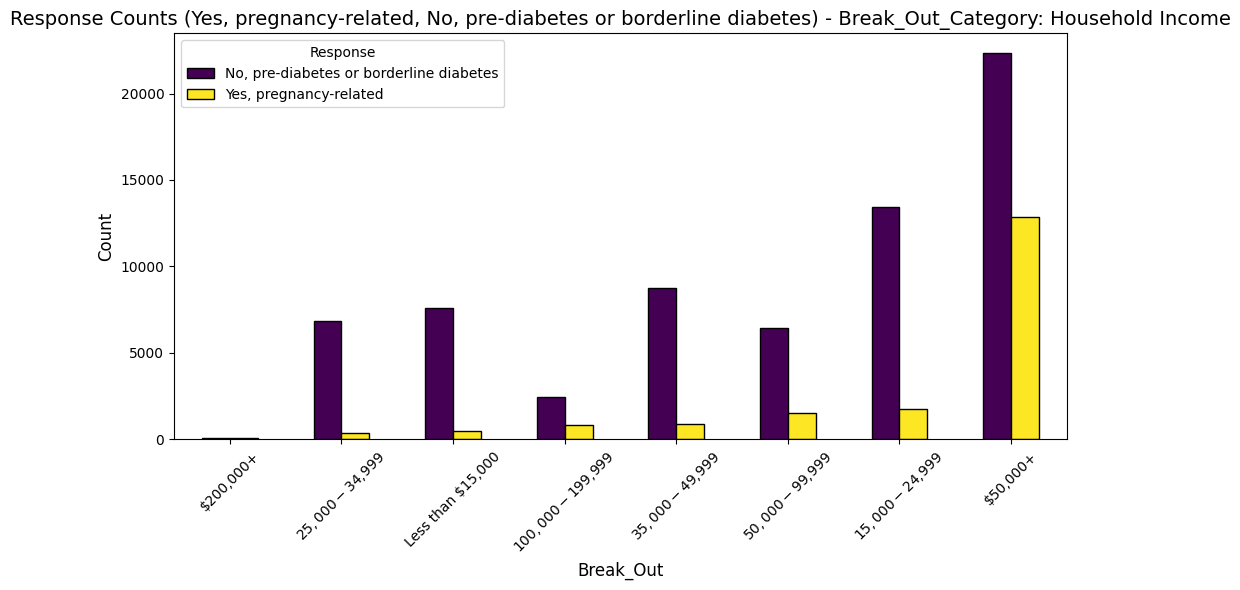

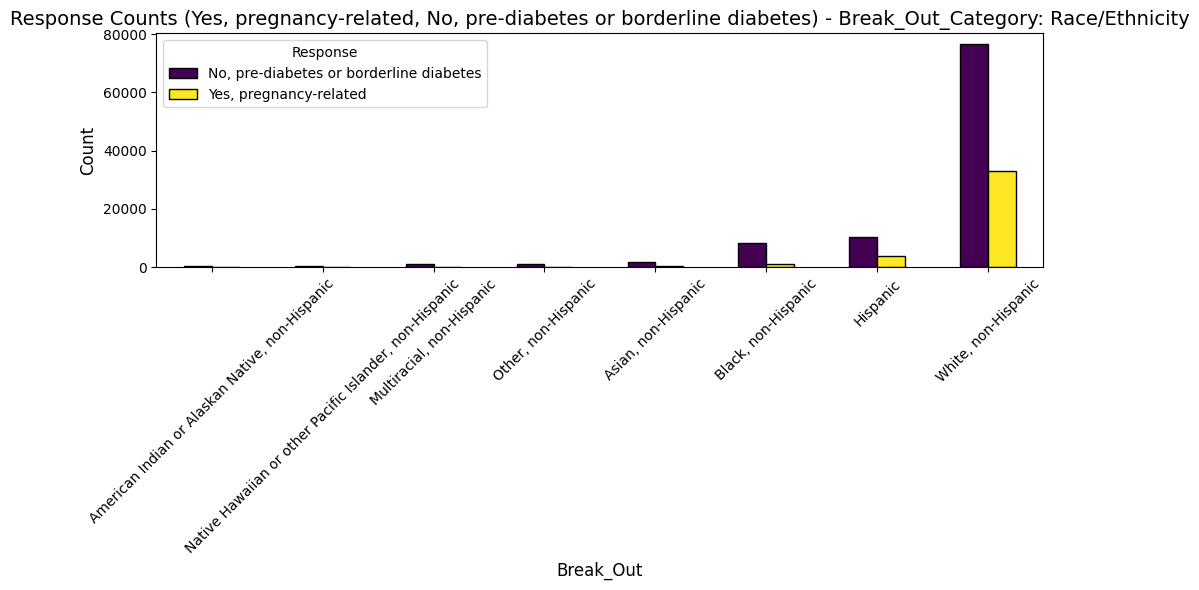

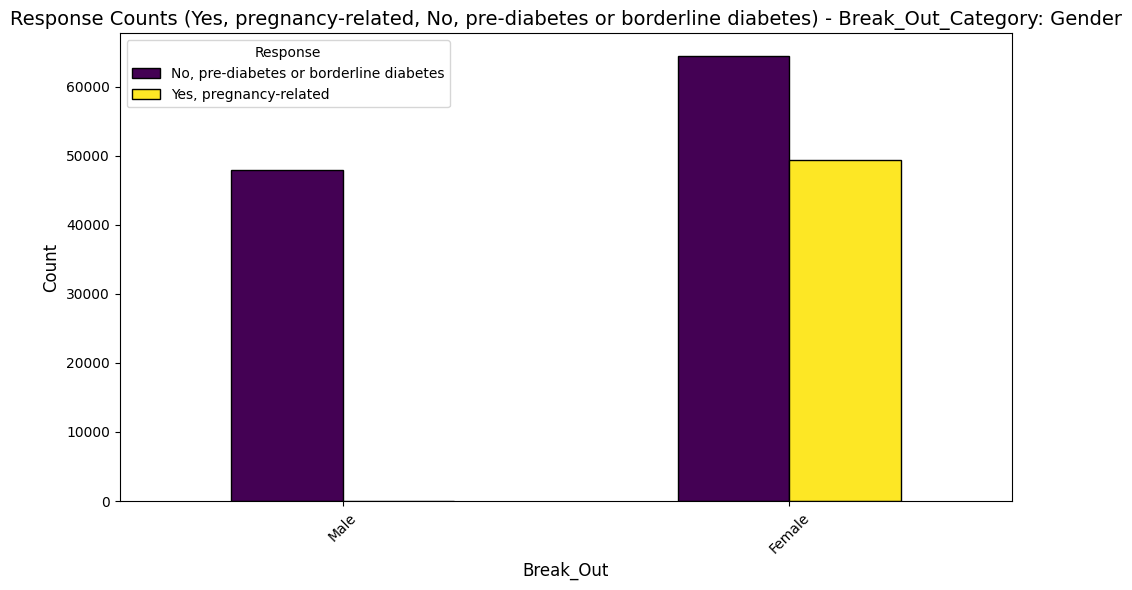

In [21]:
# Filter and plot 'Yes' and 'No' responses in the same chart for each Break_Out_Category
for category in break_out_categories:
    # Filter data for the current Break_Out_Category
    filtered_data = expanded_data[expanded_data['Break_Out_Category'] == category]
    
    # Count occurrences of 'Yes' and 'No' responses by Break_Out
    counts = filtered_data[filtered_data['Response'].isin(['Yes, pregnancy-related', 'No, pre-diabetes or borderline diabetes'])].groupby(['Break_Out', 'Response']).size().unstack(fill_value=0)
    
    # Sort by 'Yes' counts in ascending order
    if 'Yes, pregnancy-related' in counts.columns:  # Ensure 'Yes' exists to avoid errors
        counts = counts.sort_values(by='Yes, pregnancy-related', ascending=True)
    
    # Plot the results
    counts.plot(kind='bar', figsize=(10, 6), stacked=False, colormap='viridis', edgecolor='black')
    
    # Customize the plot
    plt.title(f'Response Counts (Yes, pregnancy-related, No, pre-diabetes or borderline diabetes) - Break_Out_Category: {category}', fontsize=14)
    plt.xlabel('Break_Out', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.legend(title='Response', fontsize=10)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

**Next Steps:**
- Calculate correlations and identify features to keep or drop.
- Encode the remaining features.
- Validate the final feature set using a simple model (e.g., Logistic Regression or Random Forest).
- Proceed to model training and hyperparameter tuning.